In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dismech
import csv
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting

np.concat = np.concatenate
np.bool = np.bool_

geom = dismech.GeomParams(rod_r0=0,
                          shell_h=1e-3)

material = dismech.Material(density=1200,
                            youngs_rod=0,
                            youngs_shell=2e6,
                            poisson_rod=0,
                            poisson_shell=0.5)

static_3d_sim = dismech.SimParams(static_sim=True,
                                  two_d_sim=False,
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-1,
                                  max_iter=25,
                                  total_time=1,
                                  plot_step=10,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, 0.0]))

# geo = dismech.Geometry.from_txt('four_corner.txt')
# geo = dismech.Geometry.from_txt('mesh_python_example1.txt')

# robot = dismech.SoftRobot(geom, material, geo, static_3d_sim, env)

In [2]:
# question1
# If no need to simulate to equilibirum, directly load the first state as initial state and compute the 2nd
# input_ref_kirigami_dismech.dat contains the original 3D coordinates, corresponding to zero energy state.
# input_cur_kirigami_dismech.dat contains the deformed 3D coordinates, corresponding to a non-zero energy state.

# Load both files
ref_geo = dismech.Geometry.from_txt('input_ref_kirigami_dismech.dat')
org_robot = dismech.SoftRobot(geom, material, ref_geo, static_3d_sim, env)

cur_geo = dismech.Geometry.from_txt('input_cur_kirigami_dismech.dat')
cur_robot = dismech.SoftRobot(geom, material, cur_geo, static_3d_sim, env)

# Set energy to initial state
he = dismech.HingeEnergy(org_robot.hinge_springs, org_robot.state)
se = dismech.StretchEnergy(org_robot.stretch_springs, org_robot.state)

# As the geometry is the same, you can use either state interchageably
print(he.get_energy_linear_elastic(org_robot.state), se.get_energy_linear_elastic(org_robot.state))

# From here, just generate the map using the prior functions (copied for convenience)

import csv

def write_elastic_energy_csv(data, filename="elastic_energy_total.csv", fill_value=None):
    """
    Writes a list of nested dictionaries to a CSV file with elastic energy data.

    Parameters:
    - data (list of dicts): List where each dict maps energy types to edge data.
    - filename (str): The CSV filename.
    - fill_value (float or str): Value to fill missing entries (default: None).
    """
    # Collect all unique energy types and edge IDs
    energy_types = set()
    edge_ids = set()

    for entry in data:
        for energy_type, edges in entry.items():
            energy_types.add(energy_type)
            edge_ids.update(edges.keys())

    energy_types = sorted(energy_types)  # Sort for consistent column order
    edge_ids = sorted(edge_ids)

    print("Energy Types:", energy_types)
    print("Edge IDs:", edge_ids)

    # Define CSV headers and add two extra columns for totals
    headers = ["Index", "EdgeID"]
    for et in energy_types:
        headers.extend([f"{et}Strain", f"{et}Energy"])
    headers.extend(["TotalHingeEnergy", "TotalStretchEnergy"])

    # Write to CSV
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for idx, entry in enumerate(data):
            # Compute total energies for this entry
            total_hinge = sum(
                energy for (strain, energy) in entry.get("Hinge", {}).values()
                if isinstance(energy, (int, float))
            )
            total_stretch = sum(
                energy for (strain, energy) in entry.get("Stretch", {}).values()
                if isinstance(energy, (int, float))
            )
            for edge_id in edge_ids:
                row = [idx, edge_id]
                for et in energy_types:
                    # Look up the (strain, energy) for the current edge and energy type.
                    strain, energy = entry.get(et, {}).get(edge_id, (fill_value, fill_value))
                    row.extend([strain, energy])
                # Append the total energies to the row.
                row.extend([total_hinge, total_stretch])
                writer.writerow(row)

def get_entry(state, springs, energy, nodes_to_edge_id):
    ret = {}
    strain = energy.get_strain(state)
    energy_arr = energy.get_energy_linear_elastic(state, False)
    for i, spring in enumerate(springs):
        # Both hinge and stretch first 2 nodes are around main edge
        edge_id = nodes_to_edge_id(spring.nodes_ind[:2])
        ret[int(edge_id)] = (strain[i], energy_arr[i][0])
    return ret

def get_node_to_edge_id(robot):
    def helper(edge):
        a, b = edge
        match = np.where((robot._SoftRobot__edges == [a, b]).all(
            axis=1) | (robot._SoftRobot__edges == [b, a]).all(axis=1))[0]
        return match[0] if match.size > 0 else None
    return helper

n_to_e = get_node_to_edge_id(org_robot)

# If you are only adding a single step, we only need to call get_entry once per energy

temp = {}
temp['Stretch'] = get_entry(cur_robot.state, org_robot.stretch_springs, se, n_to_e)
temp['Hinge'] = get_entry(cur_robot.state, org_robot.hinge_springs, he, n_to_e)

# Must be list of dictionaries
write_elastic_energy_csv([temp], filename='cur_kirigami_dismech_energy.csv', fill_value="-1E10")

0.0 0.0
Energy Types: ['Hinge', 'Stretch']
Edge IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 2

In [3]:
# Output connectivity matrix

def write_edge_map(robot, filename):
    headers = ["EdgeID", "N1", "N2"]
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for i, (n1, n2) in enumerate(robot._SoftRobot__edges):
            writer.writerow([i, n1, n2])

write_edge_map(org_robot, filename="connectivity.csv")

New shape: (247, 3)
Number of nodes: 247
Number of edges: 680


C:\Users\zhang\AppData\Local\Temp\ipykernel_12996\871079344.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


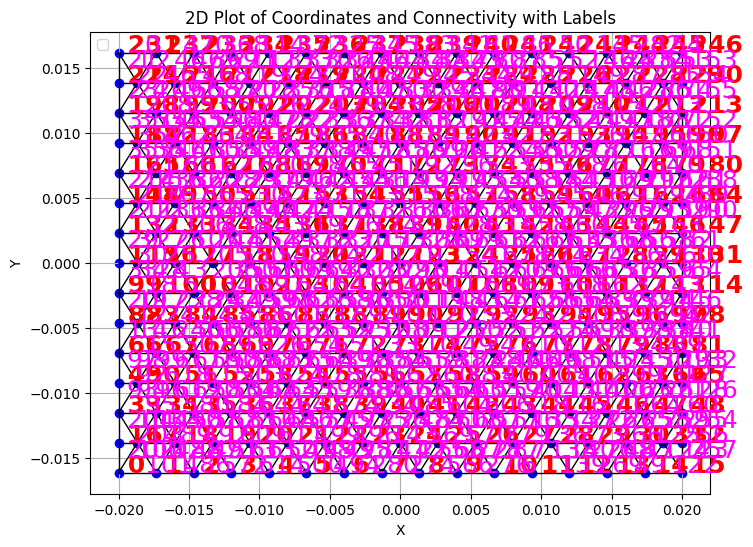

C:\Users\zhang\AppData\Local\Temp\ipykernel_12996\871079344.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


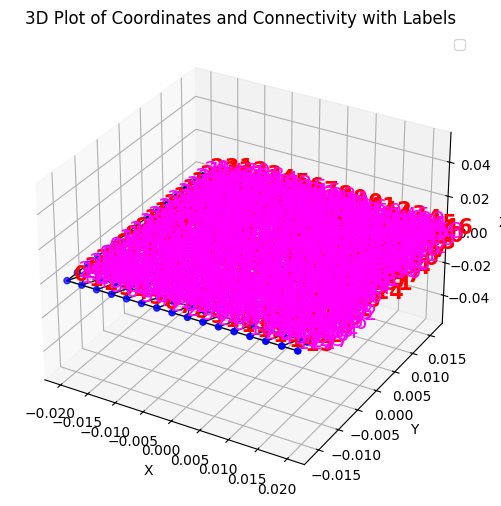

In [4]:
# Plot the original system

# Reshape node coordinates
q0_original = org_robot.q0                 # q0_original: a 1D array. (81,) for example1
coordinates = q0_original.reshape((-1, 3))  # Reshape into (27, 3), each row is [x, y, z]
print("New shape:", coordinates.shape)
# print("Coordinates:\n", coordinates)

# Get connectivity matrix from the robot
edges = org_robot._SoftRobot__edges
# print("edges", edges)

num_nodes = coordinates.shape[0]
num_edges = len(edges)
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)


# 2D Plot with connectivity
plt.figure(figsize=(8,6))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c='blue', marker='o')

# Label each node with its ID (using zero-based indexing)
for i, (x, y, _) in enumerate(coordinates):
    plt.text(x, y, f' {i}', color='red', fontsize=18, fontweight='bold')

# Draw each edge as a line between nodes (using x and y coordinates)
for edge_id, (n1, n2) in enumerate(edges):
    x_coords = [coordinates[n1, 0], coordinates[n2, 0]]
    y_coords = [coordinates[n1, 1], coordinates[n2, 1]]
    plt.plot(x_coords, y_coords, 'k-', linewidth=1)
    
    # Compute the midpoint for labeling the edge
    mid_x = (x_coords[0] + x_coords[1]) / 2
    mid_y = (y_coords[0] + y_coords[1]) / 2
    plt.text(mid_x, mid_y, f' {edge_id}', color='magenta', fontsize=18)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot of Coordinates and Connectivity with Labels')
plt.legend()
plt.grid(True)
plt.show()

# 3D Plot with connectivity
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2],
           c='blue', marker='o')

# Label each node in 3D with its ID
for i, (x, y, z) in enumerate(coordinates):
    ax.text(x, y, z, f' {i}', color='red', fontsize=15, fontweight='bold')

# Draw each edge in 3D (using x, y, and z coordinates)
for edge_id, (n1, n2) in enumerate(edges):
    x_coords = [coordinates[n1, 0], coordinates[n2, 0]]
    y_coords = [coordinates[n1, 1], coordinates[n2, 1]]
    z_coords = [coordinates[n1, 2], coordinates[n2, 2]]
    ax.plot(x_coords, y_coords, z_coords, 'k-', linewidth=1)
    
    # Compute the midpoint for labeling the edge in 3D
    mid_x = (x_coords[0] + x_coords[1]) / 2
    mid_y = (y_coords[0] + y_coords[1]) / 2
    mid_z = (z_coords[0] + z_coords[1]) / 2
    ax.text(mid_x, mid_y, mid_z, f' {edge_id}', color='magenta', fontsize=15)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Coordinates and Connectivity with Labels')
plt.legend()
plt.show()



# ------------------------------------ end of energy calculation for Abaqus results -----------------------------------

In [5]:
# ### Energy

# set strain_bar
#  instance    = package.class        (instance.object(list type), instance.instance)
stretch_energy = dismech.StretchEnergy(robot.stretch_springs, robot.state)

# FIXME: Mid-edge breaks for this!!
if robot.sim_params.use_mid_edge:
    shell_energy = dismech.TriangleEnergy(robot.triangle_springs, robot.state)
else:
    shell_energy = dismech.HingeEnergy(robot.hinge_springs, robot.state)

NameError: name 'robot' is not defined

In [5]:
# Create a robot instance (w/o gravity)
base_robot = dismech.SoftRobot(geom, material, geo, static_3d_sim, dismech.Environment())

In [ ]:
# Plot the original system

# Reshape node coordinates
q0_original = base_robot.q0                 # q0_original: a 1D array. (81,) for example1
coordinates = q0_original.reshape((-1, 3))  # Reshape into (27, 3), each row is [x, y, z]
print("New shape:", coordinates.shape)
# print("Coordinates:\n", coordinates)

# Get connectivity matrix from the robot
edges = base_robot._SoftRobot__edges
# print("edges", edges)

num_nodes = coordinates.shape[0]
num_edges = len(edges)
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)


# 2D Plot with connectivity
plt.figure(figsize=(8,6))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c='blue', marker='o')

# Label each node with its ID (using zero-based indexing)
for i, (x, y, _) in enumerate(coordinates):
    plt.text(x, y, f' {i}', color='red', fontsize=18, fontweight='bold')

# Draw each edge as a line between nodes (using x and y coordinates)
for edge_id, (n1, n2) in enumerate(edges):
    x_coords = [coordinates[n1, 0], coordinates[n2, 0]]
    y_coords = [coordinates[n1, 1], coordinates[n2, 1]]
    plt.plot(x_coords, y_coords, 'k-', linewidth=1)
    
    # Compute the midpoint for labeling the edge
    mid_x = (x_coords[0] + x_coords[1]) / 2
    mid_y = (y_coords[0] + y_coords[1]) / 2
    plt.text(mid_x, mid_y, f' {edge_id}', color='magenta', fontsize=18)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot of Coordinates and Connectivity with Labels')
plt.legend()
plt.grid(True)
plt.show()

# 3D Plot with connectivity
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2],
           c='blue', marker='o')

# Label each node in 3D with its ID
for i, (x, y, z) in enumerate(coordinates):
    ax.text(x, y, z, f' {i}', color='red', fontsize=15, fontweight='bold')

# Draw each edge in 3D (using x, y, and z coordinates)
for edge_id, (n1, n2) in enumerate(edges):
    x_coords = [coordinates[n1, 0], coordinates[n2, 0]]
    y_coords = [coordinates[n1, 1], coordinates[n2, 1]]
    z_coords = [coordinates[n1, 2], coordinates[n2, 2]]
    ax.plot(x_coords, y_coords, z_coords, 'k-', linewidth=1)
    
    # Compute the midpoint for labeling the edge in 3D
    mid_x = (x_coords[0] + x_coords[1]) / 2
    mid_y = (y_coords[0] + y_coords[1]) / 2
    mid_z = (z_coords[0] + z_coords[1]) / 2
    ax.text(mid_x, mid_y, mid_z, f' {edge_id}', color='magenta', fontsize=15)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Coordinates and Connectivity with Labels')
plt.legend()
plt.show()


In [ ]:
# BCs depend on ref coordinates from q0_original
 
print(coordinates.shape)

# coordinates is a (num_nodes, 3) numpy array, each row is [x, y, z]
tol = 1e-5

min_x = np.min(coordinates[:, 0])
max_x = np.max(coordinates[:, 0])
min_y = np.min(coordinates[:, 1])
max_y = np.max(coordinates[:, 1])

lengthx=max_x-min_x
lengthy=max_y-min_y
print("length x:", lengthx)
print("length y:", lengthy)


left_ids   = np.array(np.where(np.isclose(coordinates[:, 0], min_x, atol=tol))[0])
right_ids  = np.array(np.where(np.isclose(coordinates[:, 0], max_x, atol=tol))[0])
bottom_ids = np.where(np.isclose(coordinates[:, 1], min_y, atol=tol))[0]
top_ids    = np.where(np.isclose(coordinates[:, 1], max_y, atol=tol))[0]

print("Left boundary node IDs:", left_ids)
print("Right boundary node IDs:", right_ids)
print("Bottom boundary node IDs:", bottom_ids)
print("Top boundary node IDs:", top_ids)

# base_robot = base_robot.fix_nodes(left_ids)
# base_robot = base_robot.fix_nodes(right_ids)

# print("Fixed node IDs:", base_robot.fixed_nodes)
base_robot = base_robot.fix_nodes(np.union1d(left_ids, right_ids))

BCx=lengthx*0.2
lin = np.linspace(0, BCx, 5)

# a list of positions, each as [x, y, z]
Loadsteps = [np.array([val, 0, 0]) for val in lin]

for i, pos in enumerate(Loadsteps):
    print(f"Loadsteps2: {pos}")

print(BCx)
print(lin)
print(Loadsteps)


In [ ]:
def pull_right_end(robot: dismech.SoftRobot, t: float):
    """ Simple example of a moving boundary condition """
    u0 = 0.01
    robot = robot.move_nodes(right_ids, u0 * robot.sim_params.dt, 0)
    
    return robot

stepper = dismech.ImplicitEulerTimeStepper(base_robot)
stepper.before_step = pull_right_end

robots = stepper.simulate()

qs = np.stack([robot.state.q for robot in robots])

# question2: Given qs, how to calculate the energy he, se for each link, and total energy?

# Actually, it is better to save states instead
states = [robot.state for robot in robots]

data = []
for state in states:
    # Create a temporary array and then append the separate elastic energies into data list
    temp = {}
    temp['Stretch'] = get_entry(state, base_robot.stretch_springs, stretch_energy, n_to_e)
    temp['Hinge'] = get_entry(state, base_robot.hinge_springs, shell_energy, n_to_e)
    data.append(temp)

write_elastic_energy_csv(data, filename='from_simulate_example.csv', fill_value="-1E10")

In [ ]:
t = np.arange(base_robot.sim_params.total_time, step=base_robot.sim_params.dt)
options = dismech.AnimationOptions(y_lim=[-0.1, 0.5], x_lim=[-0.1, 0.5], # camera_view=(90,0),
                  title='Shell Stretching')
fig = dismech.get_interactive_animation_plotly(base_robot, t, qs, options)
fig.show()


In [ ]:
# BCs horizontal tension

robots = []
he = []
se = []

# Helper functions for energy
data = []   # list of dictionaries of dictionaries

def get_entry(state, springs, energy, nodes_to_edge_id):
    ret = {}
    strain = energy.get_strain(state)
    energy_arr = energy.get_energy_linear_elastic(state, False)
    for i, spring in enumerate(springs):
        # Both hinge and stretch first 2 nodes are around main edge
        edge_id = nodes_to_edge_id(spring.nodes_ind[:2])
        ret[int(edge_id)] = (strain[i], energy_arr[i][0])
    return ret

def get_node_to_edge_id(robot):
    def helper(edge):
        a, b = edge
        match = np.where((robot._SoftRobot__edges == [a, b]).all(
            axis=1) | (robot._SoftRobot__edges == [b, a]).all(axis=1))[0]
        return match[0] if match.size > 0 else None
    return helper

n_to_e = get_node_to_edge_id(robot)

# For each position, displace the node and evaluate the hinge and stretching energy
for i, pos in enumerate(Loadsteps):
    print(f"Loadstep {i}: {pos}")
    perturbation = np.tile(pos, len(right_ids))
    print(perturbation)

    disp_robot = base_robot.move_nodes(right_ids, perturbation )
    robots.append(disp_robot)
    he.append(shell_energy.get_energy_linear_elastic(disp_robot.state))
    se.append(stretch_energy.get_energy_linear_elastic(disp_robot.state))

    # Create a temporary array and then append the separate elastic energies into data list
    temp = {}
    temp['Stretch'] = get_entry(disp_robot.state, robot.stretch_springs, stretch_energy, n_to_e)
    temp['Hinge'] = get_entry(disp_robot.state, robot.hinge_springs, shell_energy, n_to_e)
    data.append(temp)
    print(f"Loadstep {i}: {pos} done")

qs = np.stack([robot.state.q for robot in robots])



In [ ]:
import plotly.graph_objects as go

all_coords = np.vstack([robot.state.q.reshape(-1, 3) for robot in robots])
xmin, xmax = all_coords[:, 0].min(), all_coords[:, 0].max()
ymin, ymax = all_coords[:, 1].min(), all_coords[:, 1].max()
zmin, zmax = all_coords[:, 2].min(), all_coords[:, 2].max()

edges = base_robot._SoftRobot__edges

frames = []
for i, robot in enumerate(robots):
    # Reshape the state vector into (N, 3)
    coords = robot.state.q.reshape(-1, 3)
    
    node_trace = go.Scatter3d(
        x=coords[:, 0],
        y=coords[:, 1],
        z=coords[:, 2],
        mode='markers',
        marker=dict(size=4, color='blue'),
        name='Nodes'
    )
    
    edge_x, edge_y, edge_z = [], [], []
    for (n1, n2) in edges:
        edge_x.extend([coords[n1, 0], coords[n2, 0], None])
        edge_y.extend([coords[n1, 1], coords[n2, 1], None])
        edge_z.extend([coords[n1, 2], coords[n2, 2], None])
        
    edge_trace = go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        mode='lines',
        line=dict(color='black', width=2),
        name='Edges'
    )
    
    frames.append(go.Frame(data=[node_trace, edge_trace], name=str(i)))

init_coords = robots[0].state.q.reshape(-1, 3)
init_node_trace = go.Scatter3d(
    x=init_coords[:, 0],
    y=init_coords[:, 1],
    z=init_coords[:, 2],
    mode='markers',
    marker=dict(size=4, color='blue'),
    name='Nodes'
)
edge_x0, edge_y0, edge_z0 = [], [], []
for (n1, n2) in edges:
    edge_x0.extend([init_coords[n1, 0], init_coords[n2, 0], None])
    edge_y0.extend([init_coords[n1, 1], init_coords[n2, 1], None])
    edge_z0.extend([init_coords[n1, 2], init_coords[n2, 2], None])
init_edge_trace = go.Scatter3d(
    x=edge_x0,
    y=edge_y0,
    z=edge_z0,
    mode='lines',
    line=dict(color='black', width=2),
    name='Edges'
)

layout = go.Layout(
    title="Interactive Animation of Loadsteps",
    scene=dict(
        xaxis=dict(range=[xmin, xmax]),
        yaxis=dict(range=[ymin, ymax]),
        zaxis=dict(range=[zmin, zmax]),
        aspectmode='cube',
        camera=dict(
            eye=dict(x=-0.6, y=2.0, z=1.0)
        )
    ),
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        y=1,
        x=1.1,
        xanchor="right",
        yanchor="top",
        buttons=[dict(label="Play",
                      method="animate",
                      args=[None, {"frame": {"duration": 500, "redraw": True},
                                   "fromcurrent": True, "transition": {"duration": 0}}]
                     )]
    )],
    sliders=[dict(
        active=0,
        pad={"t": 50},
        steps=[dict(method='animate',
                    args=[[str(k)], {"frame": {"duration": 500, "redraw": True},
                                       "mode": "immediate",
                                       "transition": {"duration": 0}}],
                    label=str(k)) for k in range(len(robots))],
        currentvalue={"prefix": "Loadstep: "}
    )]
)

fig = go.Figure(data=[init_node_trace, init_edge_trace], frames=frames, layout=layout)
fig.show()


In [ ]:
print(len(he))
print(len(se))
print(len(data))
print( len (data[0].items()  ) )
print( data[0].items() )
print(n_to_e)

In [ ]:
import csv

def write_elastic_energy_csv(data, filename="elastic_energy.csv", fill_value=None):
    """
    Writes a list of nested dictionaries to a CSV file with elastic energy data.

    Parameters:
    - data (list of dicts): List where each dict maps energy types to edge data.
    - filename (str): The CSV filename.
    - fill_value (float or str): Value to fill missing entries (default: None).
    """
    # Collect all unique energy types and edge IDs
    energy_types = set()
    edge_ids = set()

    for entry in data:
        for energy_type, edges in entry.items():
            energy_types.add(energy_type)
            edge_ids.update(edges.keys())

    energy_types = sorted(energy_types)  # Sort for consistent column order
    edge_ids = sorted(edge_ids)

    print(energy_types)
    print(edge_ids)

    # Define CSV headers
    headers = ["Index", "EdgeID"]
    for et in energy_types:
        headers.extend([f"{et}Strain", f"{et}Energy"])

    # Write to CSV
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for idx, entry in enumerate(data):
            for edge_id in edge_ids:
                row = [idx, edge_id]
                for et in energy_types:
                    strain, energy = entry.get(et, {}).get(edge_id, (fill_value, fill_value))
                    row.extend([strain, energy])
                writer.writerow(row)

# write_elastic_energy_csv(data, fill_value="NaN")
write_elastic_energy_csv(data, fill_value="-1E10")

In [ ]:
import csv

def write_elastic_energy_csv(data, filename="elastic_energy_total.csv", fill_value=None):
    """
    Writes a list of nested dictionaries to a CSV file with elastic energy data.

    Parameters:
    - data (list of dicts): List where each dict maps energy types to edge data.
    - filename (str): The CSV filename.
    - fill_value (float or str): Value to fill missing entries (default: None).
    """
    # Collect all unique energy types and edge IDs
    energy_types = set()
    edge_ids = set()

    for entry in data:
        for energy_type, edges in entry.items():
            energy_types.add(energy_type)
            edge_ids.update(edges.keys())

    energy_types = sorted(energy_types)  # Sort for consistent column order
    edge_ids = sorted(edge_ids)

    print("Energy Types:", energy_types)
    print("Edge IDs:", edge_ids)

    # Define CSV headers and add two extra columns for totals
    headers = ["Index", "EdgeID"]
    for et in energy_types:
        headers.extend([f"{et}Strain", f"{et}Energy"])
    headers.extend(["TotalHingeEnergy", "TotalStretchEnergy"])

    # Write to CSV
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for idx, entry in enumerate(data):
            # Compute total energies for this entry
            total_hinge = sum(
                energy for (strain, energy) in entry.get("Hinge", {}).values()
                if isinstance(energy, (int, float))
            )
            total_stretch = sum(
                energy for (strain, energy) in entry.get("Stretch", {}).values()
                if isinstance(energy, (int, float))
            )
            for edge_id in edge_ids:
                row = [idx, edge_id]
                for et in energy_types:
                    # Look up the (strain, energy) for the current edge and energy type.
                    strain, energy = entry.get(et, {}).get(edge_id, (fill_value, fill_value))
                    row.extend([strain, energy])
                # Append the total energies to the row.
                row.extend([total_hinge, total_stretch])
                writer.writerow(row)

# Example of calling the function with fill_value set to "-1E10"
write_elastic_energy_csv(data, fill_value="-1E10")


In [ ]:
import math

# Compare computed total energies with he and se
match_count = 0
n_entries = len(data)
print_all = True  # Set to True to print details for all entries

tol = 1e-5

for idx, entry in enumerate(data):
    hinge_data = entry.get("Hinge", {})
    stretch_data = entry.get("Stretch", {})

    # Sum numeric energy values for hinge and stretch
    total_hinge_energy = sum(
        energy for (strain, energy) in hinge_data.values()
        if isinstance(energy, (int, float))
    )
    total_stretch_energy = sum(
        energy for (strain, energy) in stretch_data.values()
        if isinstance(energy, (int, float))
    )

    # Retrieve the total energy computed earlier for this configuration
    energy_he = he[idx]
    energy_se = se[idx]

    # Check if computed totals match the stored values using tolerance
    hinge_match = math.isclose(total_hinge_energy, energy_he, rel_tol=tol)
    stretch_match = math.isclose(total_stretch_energy, energy_se, rel_tol=tol)
    if hinge_match and stretch_match:
        match_count += 1

    # Print for only the first and last entry
    if print_all or idx == 0 or idx == n_entries - 1:
        print(f"Entry {idx}:")
        print(f"  Total Hinge Energy (summed) = {total_hinge_energy}")
        print(f"  Total Hinge Energy (he)       = {energy_he}")
        print(f"  Total Stretch Energy (summed) = {total_stretch_energy}")
        print(f"  Total Stretch Energy (se)       = {energy_se}")
        print(f"  -> Hinge match: {hinge_match}, Stretch match: {stretch_match}\n")

print(f"{match_count} out of {n_entries} entries match between computed totals and he/se values.")


In [16]:
def write_q0(robot, filename):
    headers = ["NodeID", "x", "y", "z"]
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for i, (x, y, z) in enumerate(robot.q0[:robot.end_node_dof_index].reshape(-1, 3)):
            writer.writerow([i, x, y, z])
write_q0(base_robot, "test1.csv")

In [17]:
def write_qs(qs, filename):
    headers = ["index", "NodeID", "x", "y", "z"]
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for i, q in enumerate(qs):
            for j, (x, y, z) in enumerate(q[:robot.end_node_dof_index].reshape(-1, 3)):
                writer.writerow([i, j, x, y, z])

write_qs(qs, "test2.csv")